In [2]:
%%capture
!pip install k-wave-python

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from kwave.data import Vector
from kwave.kgrid import kWaveGrid
from kwave.kmedium import kWaveMedium
from kwave.kspaceFirstOrder3D import kspaceFirstOrder3D
from kwave.ksensor import kSensor
from kwave.ktransducer import kWaveTransducerSimple, NotATransducer
from kwave.kWaveSimulation import SimulationOptions

from kwave.options.simulation_execution_options import SimulationExecutionOptions
from kwave.utils.dotdictionary import dotdict
from kwave.utils.filters import spect
from kwave.utils.kwave_array import kWaveArray
from kwave.utils.plot import voxel_plot
from kwave.utils.signals import tone_burst

In [4]:
# simulation settings
DATA_CAST = 'single'

# define the grid
PML_X_SIZE = 20
PML_Y_SIZE = 10
PML_Z_SIZE = 10
Nx = 128 - 2*PML_X_SIZE
Ny = 128 - 2*PML_Y_SIZE
Nz = 64 - 2*PML_Z_SIZE
x = 40e-3
dx = x/Nx
dy = dx
dz = dx

kgrid = kWaveGrid([Nx, Ny, Nz], [dx, dy, dz])

In [25]:
%%capture
# define the medium
medium = kWaveMedium(sound_speed=1540,
                     density=1000,
                     alpha_coeff=0.75,
                     alpha_power=1.5,
                     BonA=6)

# create the time array
t_end = 40e-6
kgrid.makeTime(medium.sound_speed, t_end=t_end)

In [26]:
# define the input signal
source_strength = 1e6
tone_burst_freq = 0.5e6
tone_burst_cycles = 5
input_signal = tone_burst(1/kgrid.dt, tone_burst_freq, tone_burst_cycles)
input_signal = (source_strength/ (medium.sound_speed * medium.density)) * input_signal


In [27]:
# define the transducer
transducer = dotdict()
transducer.number_elements = 72
transducer.element_width = 1
transducer.element_length = 12
transducer.element_spacing = 0
transducer.radius = np.inf

# calculate the width of the transducer in grid points
transducer_width = transducer.number_elements * transducer.element_width + (transducer.number_elements - 1) * transducer.element_spacing

# use this to position the transducer in the middle of the computational grid
transducer.position = np.round([1, Ny / 2 - transducer_width / 2, Nz / 2 - transducer.element_length / 2])
transducer = kWaveTransducerSimple(kgrid, **transducer)

In [28]:
not_transducer = dotdict()
not_transducer.sound_speed = medium.sound_speed  # sound speed [m/s]
not_transducer.focus_distance = 20e-3  # focus distance [m]
not_transducer.elevation_focus_distance = 19e-3  # focus distance in the elevation plane [m]
not_transducer.steering_angle = 0  # steering angle [degrees]
not_transducer.transmit_apodization = "Rectangular"
not_transducer.receive_apodization = "Rectangular"
not_transducer.active_elements = np.zeros((transducer.number_elements, 1))
not_transducer.active_elements[21:52] = 1
not_transducer.input_signal = input_signal

not_transducer = NotATransducer(transducer, kgrid, **not_transducer)

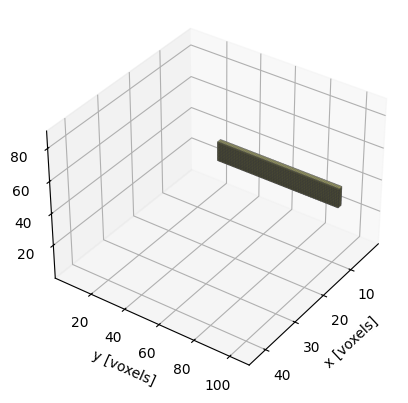

In [29]:
%matplotlib inline
voxel_plot(np.single(not_transducer.all_elements_mask))

In [42]:
# define sensor mask
sensor_mask = np.zeros((Nx, Ny, Nz))
sensor_mask[Nx//4, Ny//2, Nz//2] = 1
sensor_mask[Nx//2, Ny//2, Nz//2] = 1
sensor_mask[3*Nx//4, Ny//2, Nz//2] = 1
sensor = kSensor(sensor_mask)
sensor.record=['p']

# SIMULATION
simulation_options = SimulationOptions(
    pml_inside=False,
    pml_size=Vector([PML_X_SIZE, PML_Y_SIZE, PML_Z_SIZE]),
    data_cast=DATA_CAST,    
    save_to_disk=True,
)

execution_options = SimulationExecutionOptions(is_gpu_simulation=True)

sensor_data = kspaceFirstOrder3D(medium=medium, kgrid=kgrid, source=not_transducer, sensor=sensor,
                                  simulation_options=simulation_options, execution_options=execution_options)


┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                             NVIDIA RTX A4000 │
│ Number of CPU threads:                                     20 │
│ Processor name:           12th Gen Intel(R) Core(TM) i7-12700 │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                             128 x 128 x 64 │
│ Medium type:                                               3D │
│ Simulation time steps:                                    452 │
├───────────────────────────────────────────────────────────────┤
│         

In [45]:

f_input, as_input, _ = spect(input_signal, 1/kgrid.dt)
_, as_1, _ = spect(sensor_data['p'][:, 0], 1/kgrid.dt)
_, as_2, _ = spect(sensor_data['p'][:, 1], 1/kgrid.dt)
f, as_3, _ = spect(sensor_data['p'][:, 2], 1/kgrid.dt)

(0.0, 1.694)

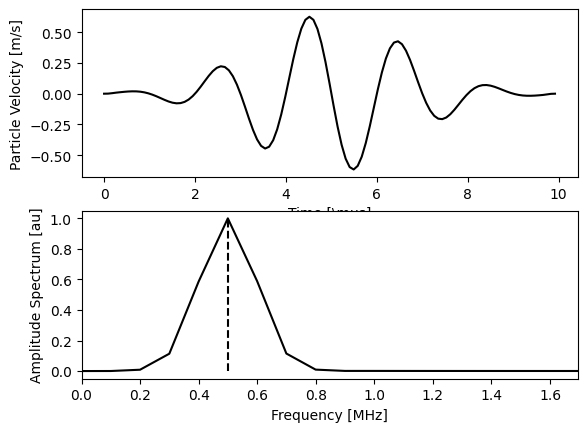

In [46]:
fig, axes = plt.subplots(2,1)
axes[0].plot(np.arange(0,input_signal.shape[-1]) * kgrid.dt * 1e6, input_signal.T, 'k-')
axes[0].set_xlabel('Time [\mus]')
axes[0].set_ylabel('Particle Velocity [m/s]')

axes[1].plot(f_input/1e6, np.squeeze(as_input/np.max(as_input)), 'k-')
axes[1].plot([tone_burst_freq/1e6, tone_burst_freq/1e6], [0, 1], 'k--')
axes[1].set_xlabel('Frequency [MHz]')
axes[1].set_ylabel('Amplitude Spectrum [au]')
f_max = medium.sound_speed / (2*dx)
axes[1].set_xlim([0, f_max/1e6])



(0.0, 1.694)

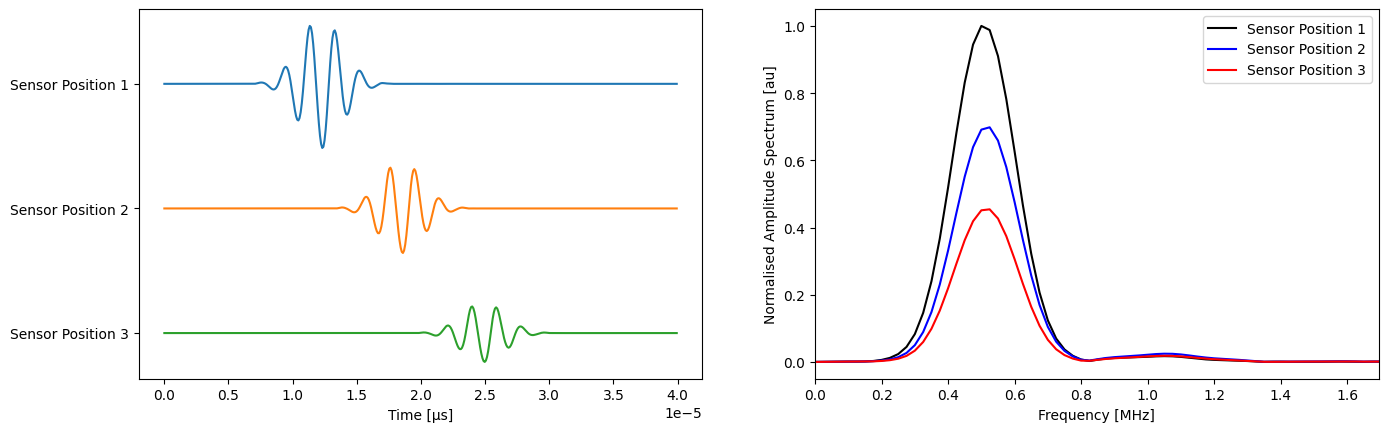

In [77]:
# Creating a dictionary with the step labels as keys
sensor_positions = {
    'Sensor Position 1': sensor_data['p'][:,0],
    'Sensor Position 2': sensor_data['p'][:,1],
    'Sensor Position 3': sensor_data['p'][:,2]
}

fig, axes = plt.subplots(1,2)
fig.set_figwidth(16)
fig.tight_layout = True

offset = -30e5
# Plotting each step using the dictionary
for i, (label, data) in enumerate(sensor_positions.items()):
    axes[0].plot(kgrid.t_array.squeeze()[:len(data.squeeze())], data.squeeze() + offset * i, label=label)

# Set y-ticks and y-labels
axes[0].set_yticks([offset * i for i in range(len(sensor_positions.keys()))], list(sensor_positions.keys()))
axes[0].set_xlabel('Time [\u03BCs]')


axes[1].plot(f * 1e-6, as_1 / np.max(as_1.flatten()), 'k-', label = 'Sensor Position 1')
axes[1].plot(f * 1e-6, as_2 / np.max(as_1.flatten()), 'b-', label = 'Sensor Position 2')
axes[1].plot(f * 1e-6, as_3 / np.max(as_1.flatten()), 'r-', label = 'Sensor Position 3')
axes[1].legend()
axes[1].set_xlabel('Frequency [MHz]')
axes[1].set_ylabel('Normalised Amplitude Spectrum [au]');
f_max = medium.sound_speed / (2 * dx)
axes[1].set_xlim([0, f_max * 1e-6])
